In [1]:
## HYPERTUNING GRU/LSTM vs layers

In [1]:
import time
import numpy as np
from plotly import graph_objects as go
import matplotlib.pyplot as plt

from loguru import logger

import ray
from ray import tune

import torch
from torch import optim
from torch import nn

from pathlib import Path

%matplotlib inline
plt.style.use('dark_background')
# import plotly.io as pio
# pio.renderers.default = 'plotly_mimetype+notebook'

import visualize
DELETE = True # to delete the tunedir at the end of the notebook
start = time.time()

```
config = {
    "uniform": tune.uniform(-5, -1),  # Uniform float between -5 and -1
    "quniform": tune.quniform(3.2, 5.4, 0.2),  # Round to multiples of 0.2
    "loguniform": tune.loguniform(1e-4, 1e-1),  # Uniform float in log space
    "qloguniform": tune.qloguniform(1e-4, 1e-1, 5e-5),  # Round to multiples of 0.00005
    "randn": tune.randn(10, 2),  # Normal distribution with mean 10 and sd 2
    "qrandn": tune.qrandn(10, 2, 0.2),  # Round to multiples of 0.2
    "randint": tune.randint(-9, 15),  # Random integer between -9 and 15
    "qrandint": tune.qrandint(-21, 12, 3),  # Round to multiples of 3 (includes 12)
    "lograndint": tune.lograndint(1, 10),  # Random integer in log space
    "qlograndint": tune.qlograndint(1, 10, 2),  # Round to multiples of 2
    "choice": tune.choice(["a", "b", "c"]),  # Choose one of these options uniformly
    "func": tune.sample_from(
        lambda spec: spec.config.uniform * 0.01
    ),  # Depends on other value
    "grid": tune.grid_search([32, 64, 128]),  # Search over all these values
}
```

This is a general reference notebook to explore the use of ray tuner.
First, we define some global variables. This makes it easier to change the parameters for the full notebook at once and run everything.


In [2]:
MAX_EPOCHS = 5
N_EXPERIMENTS = 18

# Train function and config

Let's define some dicts to log the results of the training.

In [12]:
timer = {}
best_config = {}


We will need a training function. This is also implemented in the mltrainer, but I put it here to show you how the details work.

In [13]:
def train_fn(model, trainstreamer, lossfn, optimizer, steps):
    model.train()
    train_loss: float = 0.0
    for _ in range(steps):
        x, y = next(trainstreamer)
        optimizer.zero_grad()
        yhat = model(x)
        loss = lossfn(yhat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

We validate on the validation set and return the loss.

In [14]:
def validate(model, validstreamer, lossfn, metric, steps):
    model.eval()
    valid_loss: float = 0.0
    acc: float = 0.0
    with torch.no_grad():
        for _ in range(steps):
            x, y = next(validstreamer)
            yhat = model(x)
            loss = lossfn(yhat, y)
            valid_loss += loss.item()
            acc += metric(y, yhat)
    acc /= steps
    return valid_loss, acc.item()

Getting the data requires a bit extra care. Because we will run experiments in parallel on all the cpu's available, we well use FileLock to make sure that loading the data does not conflict.

Note we import functions inside the function we will later on pass to ray. This is because ray will serialize the function and send it to the workers. If we import the functions outside the function, the workers will not have access to them.

In [15]:
def get_data(tune_dir):
    from filelock import FileLock
    from mads_datasets import DatasetFactoryProvider, DatasetType
    from mltrainer.preprocessors import PaddedPreprocessor
    from mads_datasets import DatasetFactoryProvider, DatasetType
    with FileLock(tune_dir / ".lock"):
        # we lock the datadir to avoid parallel instances trying to
        # access the datadir
        preprocessor = PaddedPreprocessor()
        gesturesdatasetfactory = DatasetFactoryProvider.create_factory(DatasetType.GESTURES)
        streamers = gesturesdatasetfactory.create_datastreamer(
            batchsize=32, preprocessor=preprocessor
        )
        train = streamers["train"]
        valid = streamers["valid"]
    return train, valid

We will use the same GRU model we used last lesson. You might improve this in a few ways (eg consider adding skip layers, conv1d, etc) but for clarity, lets keep it simple.

In [126]:
class GRUmodel(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        print(config)
        self.rnn = nn.GRU(
            input_size=config["input_size"],
            hidden_size=int(config["hidden_size"]),
            dropout=config["dropout"],
            batch_first=True,
            num_layers=int(config["num_layers"]),
        )
        self.linear = nn.Linear(int(config["hidden_size"]), config["output_size"])

    def forward(self, x):
        x, _ = self.rnn(x)
        last_step = x[:, -1, :]
        yhat = self.linear(last_step)
        return yhat

In [127]:
class LSTMmodel(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        print(config)
        self.rnn = nn.LSTM(
            input_size=config["input_size"],
            hidden_size=int(config["hidden_size"]),
            dropout=config["dropout"],
            batch_first=True,
            num_layers=int(config["num_layers"]),
        )
        self.linear = nn.Linear(int(config["hidden_size"]), config["output_size"])

    def forward(self, x):
        x, _ = self.rnn(x)
        last_step = x[:, -1, :]
        yhat = self.linear(last_step)
        return yhat

In [128]:
#torch.nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)

Now, we have all the ingredients we need to run the tuner.
We create a function that:
- loads the data with a lock
- creates the model
- trains the model
- validates the model
- reports the results to ray

In [129]:
def tune_model(config: dict):
    from mltrainer.metrics import Accuracy

    # load data
    train, valid = get_data(config["tune_dir"])
    trainsteps = len(train)
    validsteps = len(valid)
    trainstreamer = train.stream()
    validstreamer = valid.stream()

    # create model with config
    model = GRUmodel(config)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    metric = Accuracy()

    for _ in range(config["epochs"]):
        # train and validate
        train_loss = train_fn(model, trainstreamer, loss_fn, optimizer, trainsteps)
        valid_loss, accuracy = validate(model, validstreamer, loss_fn, metric, validsteps)

        # report to ray
        ray.train.report({
            "valid_loss": valid_loss / validsteps,
            "train_loss": train_loss / trainsteps,
            "accuracy" : accuracy,
            })


In [136]:
def tune_two_models(config):
    from mltrainer.metrics import Accuracy

    # load data
    train, valid = get_data(config["tune_dir"])
    trainsteps = len(train)
    validsteps = len(valid)
    trainstreamer = train.stream()
    validstreamer = valid.stream()
    print(config["hidden_size"])
    # create model with config
    if config["choice"] == 1:
        model = GRUmodel(config)
    else:
        model = LSTMmodel(config)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    metric = Accuracy()

    for _ in range(config["epochs"]):
        # train and validate
        train_loss = train_fn(model, trainstreamer, loss_fn, optimizer, trainsteps)
        valid_loss, accuracy = validate(model, validstreamer, loss_fn, metric, validsteps)

        # report to ray
        ray.train.report({
            "valid_loss": valid_loss / validsteps,
            "train_loss": train_loss / trainsteps,
            "accuracy" : accuracy,
            })

Let's try this, to see if everything works as expected.
Note that it typically does not make sense to use accelaration here; we will typically have 1 GPU, but 10 or 16 CPUS. We gain much more from parallelizing the experiments than we gain by running the model faster on a single GPU.

In [131]:
tune_dir = Path("models/ray/").resolve()
tune_dir

WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray')

In [132]:
config = {
    "input_size": 3,
    "output_size": 20,
    "dropout": 0.1,
    "epochs": MAX_EPOCHS,
    "hidden_size": tune.randint(400, 612),
    "num_layers": tune.randint(1, 8),
    "tune_dir": tune_dir,
}

In [142]:
from ray import tune


config = {
    "input_size": 3,
    "output_size": 20,
    "dropout": 0.1,
    "hidden_size": tune.randint(400, 1024),
    "num_layers": tune.randint(4, 10),
    "epochs": MAX_EPOCHS,
    "tune_dir": tune_dir,
    "choice": tune.choice([0, 1])
    
    
}


In [143]:
config

{'input_size': 3,
 'output_size': 20,
 'dropout': 0.1,
 'hidden_size': <ray.tune.search.sample.Integer at 0x1f6ee8d2f50>,
 'num_layers': 4,
 'epochs': 5,
 'tune_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray'),
 'choice': <ray.tune.search.sample.Categorical at 0x1f6ee6b2320>}

# Random search

Now, let's do a random search. 

First, we define the search space. We can specify specific values, but also distributions.
For the hidden size, we will use randint, which will sample from a uniform distribution of integers.
The same for the number of layers.

The `tune.run` function runs the hypertuning. It will sample from the search space, and create a specific config for each experiment.

Let's test this!

In [144]:
config

{'input_size': 3,
 'output_size': 20,
 'dropout': 0.1,
 'hidden_size': <ray.tune.search.sample.Integer at 0x1f6ee8d2f50>,
 'num_layers': 4,
 'epochs': 5,
 'tune_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray'),
 'choice': <ray.tune.search.sample.Categorical at 0x1f6ee6b2320>}

In [145]:
tic = time.time()
analysis = tune.run(
    tune_two_models,
    config=config,
    metric="valid_loss",
    mode="min",
    storage_path=str(tune_dir),
    num_samples=N_EXPERIMENTS,
    stop={"training_iteration": MAX_EPOCHS},
    verbose=1,
)

timer["ray_random"] = time.time() - tic


2024-12-12 20:59:51,741	WARNING util.py:201 -- The `on_step_begin` operation took 3.010 s, which may be a performance bottleneck.
2024-12-12 21:03:32,441	WARNING util.py:201 -- The `on_step_begin` operation took 8.632 s, which may be a performance bottleneck.
2024-12-12 21:06:39,412	WARNING util.py:201 -- The `on_step_begin` operation took 4.756 s, which may be a performance bottleneck.
2024-12-12 21:51:13,964	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray/tune_two_models_2024-12-12_20-51-43' in 0.0580s.
2024-12-12 21:51:13,985	INFO tune.py:1041 -- Total run time: 3570.96 seconds (3570.85 seconds for the tuning loop).


In [146]:
def plot_contour(df, x, y, z, start=0.90, end=1.0, size=0.01):
    fig = go.Figure()

    fig.add_trace(
        go.Contour(
            z=df[z],
            x=df[x],
            y=df[y],
            contours=dict(
                coloring='heatmap',
                showlabels=True,  # show labels on contours
                start=start,       # start of the contour range
                end=end,          # end of the contour range
                size=size,
            ),
            colorscale="plasma",
            colorbar=dict(
                title='Accuracy'
            )
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df[x],
            y=df[y],
            mode='markers',
            marker=dict(
                color='black',
                size=8,
                symbol='circle'
            ),
            customdata=df['accuracy'],  # Pass accuracy values for hover text
            hovertemplate=(
                'Hidden Size: %{x}<br>'
                'Number of Layers: %{y}<br>'
                'Accuracy: %{customdata:.4f}<extra></extra>'
            ),
            name='Data Points'
        )
    )

    fig.update_layout(
        title="Contour Plot",
        xaxis_title="Hidden Size",
        yaxis_title="Number of Layers",
        xaxis=dict(showgrid=False),  # Remove x-axis grid lines
        yaxis=dict(showgrid=False),
        plot_bgcolor='white',        # Set background color to white
        paper_bgcolor='white'
    )

    fig.show()

In [ ]:
def plot_contour_categorical(df, x, y, z, start=0.90, end=1.0, size=0.01):
    fig = go.Figure()

    fig.add_trace(
        go.Contour(
            z=df[z],
            x=df[x],
            y=df[y],
            contours=dict(
                coloring='heatmap',
                showlabels=True,  # show labels on contours
                start=start,       # start of the contour range
                end=end,          # end of the contour range
                size=size,
            ),
            colorscale="plasma",
            colorbar=dict(
                title='Accuracy'
            )
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df[x],
            y=df[y],
            mode='markers',
            marker=dict(
                color='black',
                size=8,
                symbol='circle'
            ),
            customdata=df['accuracy'],  # Pass accuracy values for hover text
            hovertemplate=(
                'Hidden Size: %{x}<br>'
                'Number of Layers: %{y}<br>'
                'Accuracy: %{customdata:.4f}<extra></extra>'
            ),
            name='Data Points'
        )
    )

    fig.update_layout(
        title="Contour Plot",
        xaxis_title="Hidden Size",
        yaxis_title="Number of Layers",
        xaxis=dict(showgrid=False),  # Remove x-axis grid lines
        yaxis=dict(showgrid=False),
        plot_bgcolor='white',        # Set background color to white
        paper_bgcolor='white'
    )

    fig.show()

In [147]:
all_results = analysis.results_df
all_results.columns

Index(['valid_loss', 'train_loss', 'accuracy', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/input_size', 'config/output_size', 'config/dropout',
       'config/hidden_size', 'config/num_layers', 'config/epochs',
       'config/tune_dir', 'config/choice'],
      dtype='object')

In [148]:
lstm = all_results[all_results['config/choice']=='LSTM']
plot_contour(lstm, "config/choice", "config/num_layers", "accuracy")

As you can see, the search space is sort of randomly sampled.
Even though big parts are unexplored, it still looks like we find some hotspots.

In [149]:
best = analysis.get_best_config()
best["accuracy"] = analysis.best_result["accuracy"]
best_config["random"] = best

So, we searched the hyperparameter space. Problem is, these spaces potentially can get
pretty big. Let's imagine you have 10 hyperparameters, and every hyperparameter has 5
possible (relevant) values, you already have $5^{10}$ possible combinations, which is almost 10 million. Even if checking of every configuration would take just 1 second, it would take more than a 100 days to check them all...This
space can grow out of control pretty fast.

Lets look at the best results we found.

In [150]:
best

{'input_size': 3,
 'output_size': 20,
 'dropout': 0.1,
 'hidden_size': 886,
 'num_layers': 4,
 'epochs': 5,
 'tune_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray'),
 'choice': 1,
 'accuracy': 0.9937499761581421}

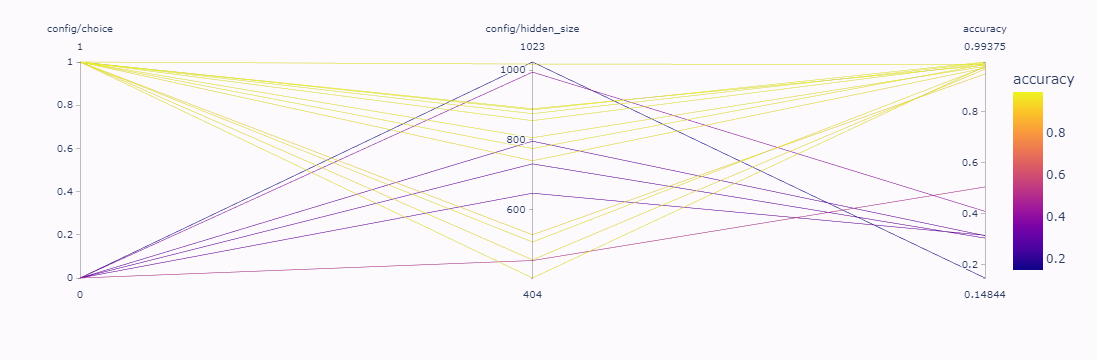

In [153]:
columns = ["config/choice", "config/hidden_size",  "accuracy"]
visualize.parallel_plot(analysis, columns)

Note how the mean scores are sort of randomly distributed. This is a direct
effect of random guessing parameters.

# Grid search

We can do this more rigorous with a gridsearch.
The upside of this technique is that you will test every configuration.

A huge downside is the inefficiency. Also, you will run experiments with combinations that might be not very promising, but very slow, which is pretty inefficient.


One way to handle this is to use doubling as a strategy to scan the range: 16, 32, ..., 512. This is a bit more efficient.

Typically, this can be a good idea for a first scan, to get a rough idea of the space.
After you have done this, you can narrow your searchspace, and do a more fine grained search zoomed in on areas that seem promising.

In [54]:
config = {
    "input_size": 3,
    "output_size": 20,
    "dropout": 0.1,
    "epochs": MAX_EPOCHS,
    "hidden_size": tune.grid_search([16, 32, 64, 128, 256, 512]),
    "num_layers": tune.grid_search([2, 4, 8]),
    "tune_dir": tune_dir,
}

In [56]:

tic = time.time()

analysis = tune.run(
    tune_model,
    config=config,
    metric="valid_loss",
    mode="min",
    storage_path=str(tune_dir),
    stop={"training_iteration": MAX_EPOCHS},
    verbose=1,
)

timer["ray_grid"] = time.time() - tic

best = analysis.get_best_config()
best["accuracy"] = analysis.best_result["accuracy"]
best_config["grid"] = best

2024-12-10 18:53:25,212	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray/tune_model_2024-12-10_18-42-24' in 0.0565s.
2024-12-10 18:53:25,231	INFO tune.py:1041 -- Total run time: 660.75 seconds (660.64 seconds for the tuning loop).


In [57]:
import pandas as pd
all_results = pd.concat([all_results, analysis.results_df])

In [58]:
grid = analysis.results_df
plot_contour(grid, "config/hidden_size", "config/num_layers", "accuracy", start=0.7)

In [62]:
best_grid = analysis.get_best_config()
best_grid

{'input_size': 3,
 'output_size': 20,
 'dropout': 0.1,
 'epochs': 5,
 'hidden_size': 512,
 'num_layers': 2,
 'tune_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray'),
 'accuracy': 0.9984375238418579}

As you can see, we get a systematic scan, but large parts of the space are still unexplored, and we also explored parts that are really not very promising.

In [59]:
visualize.parallel_plot(analysis, columns)

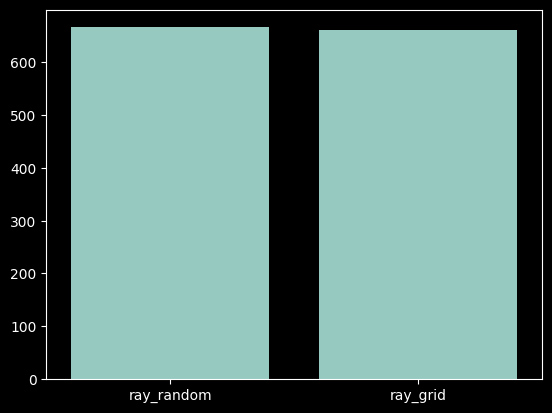

In [60]:
visualize.plot_timers(timer)

# Bayes

Now, we improve the search algorithm with a bayesian optimization.

Note that the bayesian search algorithm will only work with continuous parameters. This is a problem for the number of layers, which is a discrete parameter. I fixed this by simply casting the parameters to an integer inside the model, which is not very elegant but it works.

In [67]:
!pip install bayesian-optimization

In [64]:
!pip install bayesian-optimization

Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388


In [69]:
from ray.tune.search.bayesopt import BayesOptSearch

bayesopt = BayesOptSearch(random_search_steps=5)


config = {
    "input_size": 3,
    "output_size": 20,
    "dropout": 0.1,
    "epochs": MAX_EPOCHS,
    "hidden_size": tune.uniform(16, 512),
    "num_layers": tune.uniform(1, 8),
    "tune_dir": tune_dir,
}

tic = time.time()

analysis = tune.run(
    tune_model,
    config=config,
    metric="valid_loss",
    mode="min",
    local_dir=str(tune_dir),
    num_samples=N_EXPERIMENTS,
    stop={"training_iteration": MAX_EPOCHS},
    search_alg=bayesopt,
    verbose=1,
)

timer["ray_bayes"] = time.time() - tic

best = analysis.get_best_config()
best["accuracy"] = analysis.best_result["accuracy"]
best_config["bayes"] = best


AttributeError: module 'bayes_opt' has no attribute 'UtilityFunction'

In [ ]:
best

In [ ]:
all_results = pd.concat([all_results, analysis.results_df])

In [ ]:
bayes = analysis.results_df
plot_contour(bayes, "config/hidden_size", "config/num_layers", "accuracy", start=0.7)

As you can see, bayes really focuses on the promising areas. It is much more efficient than random search, and also more efficient than grid search.
We have set the `random_search_steps` to 5, this means that we will do 5 random searches first, to get a good initial idea of the space. As you can see, 5 is a bit low, because it might lead to premature converging to a local optimum. You can increase this number to get a better initial idea of the space, but you will also need to increase the number of iterations after the initial random scan.

In [ ]:
visualize.parallel_plot(analysis, columns)

In [ ]:
visualize.plot_timers(timer)

In [ ]:
import pandas as pd

pd.DataFrame.from_dict(best_config, orient="index")


# Hyperband

Hyperband aborts runs early. Configs that are unpromising are abandoned before they complete.

In [70]:
from ray.tune.schedulers import AsyncHyperBandScheduler

scheduler = AsyncHyperBandScheduler(
    time_attr="training_iteration", grace_period=1, reduction_factor=3, max_t=MAX_EPOCHS
)

config = {
    "input_size": 3,
    "output_size": 20,
    "dropout": 0.1,
    "epochs": MAX_EPOCHS,
    "hidden_size": tune.randint(16, 512),
    "num_layers": tune.randint(1, 8),
    "tune_dir": tune_dir,
}

tic = time.time()
analysis = tune.run(
    tune_model,
    config=config,
    metric="valid_loss",
    mode="min",
    storage_path=str(tune_dir),
    num_samples=N_EXPERIMENTS,
    stop={"training_iteration": MAX_EPOCHS},
    scheduler=scheduler,
    verbose=1,
)

timer["ray_hyperband"] = time.time() - tic

best = analysis.get_best_config()
best["accuracy"] = analysis.best_result["accuracy"]
best_config["hyperband"] = best


2024-12-10 19:06:21,497	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray/tune_model_2024-12-10_18-58-43' in 0.0588s.
2024-12-10 19:06:21,515	INFO tune.py:1041 -- Total run time: 458.25 seconds (458.15 seconds for the tuning loop).


If you study the iter column, you will see that some runs have been stopped early. This is exactly the point of hyperband: it tries to allocate resources to the most promising configurations.

The downside of this, is that if you try to get a good view of the space, you get distorted results because comparing a model that has trained just 1 or 3 epochs with a model that has trained 100 epochs is not very fair...

In [71]:
all_results = pd.concat([all_results, analysis.results_df])

In [72]:
hyperband = analysis.results_df
plot_contour(hyperband, "config/hidden_size", "config/num_layers", "accuracy", start=0.7)

In [76]:
best_hyperband = analysis.get_best_config()
best_hyperband

{'input_size': 3,
 'output_size': 20,
 'dropout': 0.1,
 'epochs': 5,
 'hidden_size': 482,
 'num_layers': 3,
 'tune_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray'),
 'accuracy': 0.981249988079071}

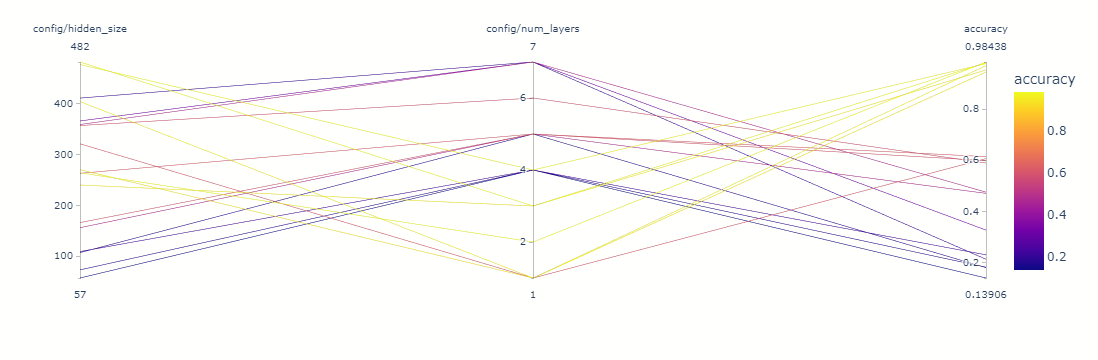

In [77]:
visualize.parallel_plot(analysis, columns)


But note that it is faster! This means you could do more runs in the same time, which might be a good tradeoff!
Typically you will get better results if you scan the searchspace better by doing more runs, aborting the ones that are not promising and going on with the ones that seem to yield good results.

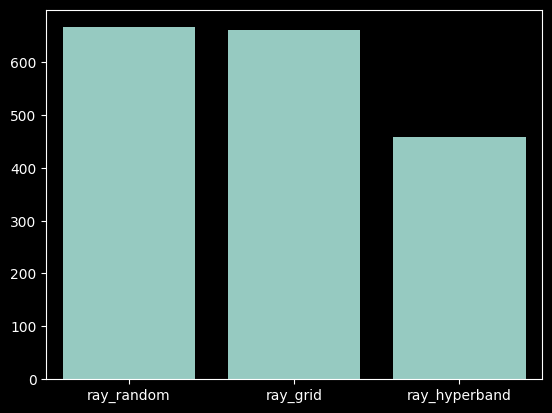

In [74]:
visualize.plot_timers(timer)


In [75]:
pd.DataFrame.from_dict(best_config, orient="index")

,input_size,output_size,dropout,epochs,hidden_size,num_layers,tune_dir,accuracy
random,3,20,0.05,5,497,4,C:\Users\Francesca\Documents\osint\code_repo\A...,0.989062
grid,3,20,0.10,5,512,2,C:\Users\Francesca\Documents\osint\code_repo\A...,0.998438
hyperband,3,20,0.10,5,482,3,C:\Users\Francesca\Documents\osint\code_repo\A...,0.981250


# Hyperbayes

It is possible to combine Hyperband with Bayesian optimization, implemented as `TuneBOHB` in ray.
However, `TuneBOHB` in ray is dependent on `hpbandster`, which is not mainained anymore.
Unfortunately, a dependency of `hpbandster` is `netifaces`, which is also not maintained anymore.
While `netifaces` does work on some hardware, it fails to build on some other hardware, which is a problem.

To still use BOHB type algoritms, I am planning to implement either SMAC3 or BEHB in the future.


# HyperOpt - tree search algorithm

In [78]:
from ray.tune.search.hyperopt import HyperOptSearch
search = HyperOptSearch()

scheduler = AsyncHyperBandScheduler(
    time_attr="training_iteration", grace_period=1, reduction_factor=3, max_t=MAX_EPOCHS
)

In [80]:
config = {
    "input_size": 3,
    "output_size": 20,
    "dropout": 0.1,
    "epochs": MAX_EPOCHS,
    "hidden_size": tune.randint(16, 512),
    "num_layers": tune.randint(1, 8),
    "tune_dir": tune_dir,
}

tic = time.time()
analysis = tune.run(
    tune_model,
    config=config,
    metric="valid_loss",
    mode="min",
    storage_path=str(tune_dir),
    num_samples=N_EXPERIMENTS,
    stop={"training_iteration": MAX_EPOCHS},
    search_alg=search,
    scheduler=scheduler,
    verbose=1,
)

timer["ray_hyperopt"] = time.time() - tic

best = analysis.get_best_config()
best["accuracy"] = analysis.best_result["accuracy"]
best_config["hyperopt"] = best


2024-12-10 19:07:50,225	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\FRANCE~1\AppData\Local\Temp\ray\session_2024-12-10_16-07-08_104912_3452\artifacts\2024-12-10_19-07-50\tune_model_2024-12-10_19-07-50\driver_artifacts\tune_model_101bbbe1_1_dropout=0.1000,epochs=5,hidden_size=375,input_size=3,num_layers=5,output_size=20,tune_dir=ref_ph_b1421250_2024-12-10_19-07-50
2024-12-10 19:07:50,241	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\FRANCE~1\AppData\Local\Temp\ray\session_2024-12-10_16-07-08_104912_3452\artifacts\2024-12-10_19-07-50\tune_model_2024-12-10_19-07-50\driver_artifacts\tune_model_101bbbe1_1_dropout=0.1000,epochs=5,hidden_size=375,input_size=3,num_layers=5,output_size=20,tune_dir=ref_ph_b1421250_2024-12-10_19-07-50
2024-12-10 19:07:55,923	WA

In [81]:
all_results = pd.concat([all_results, analysis.results_df])

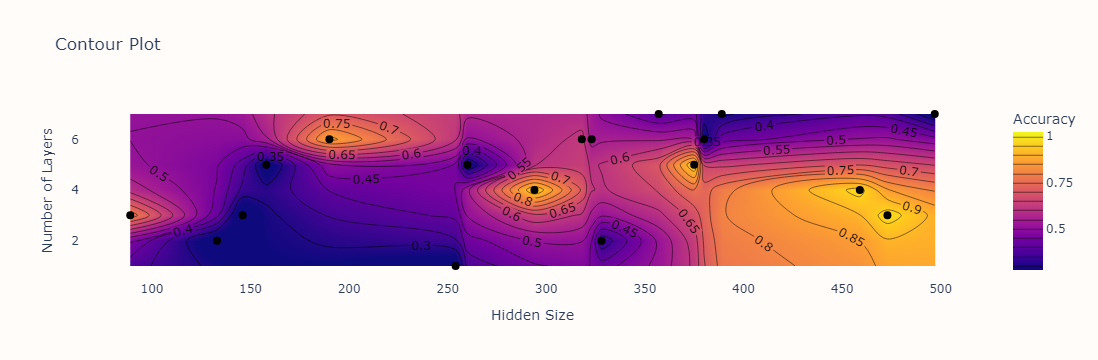

In [82]:
hyperbayes = analysis.results_df
plot_contour(hyperbayes, "config/hidden_size", "config/num_layers", "accuracy", start=0.3, size=0.05)


This model combines bayesian optimization with hyperband. This is a good idea, because it combines the efficiency of bayesian optimization with the speed of hyperband.

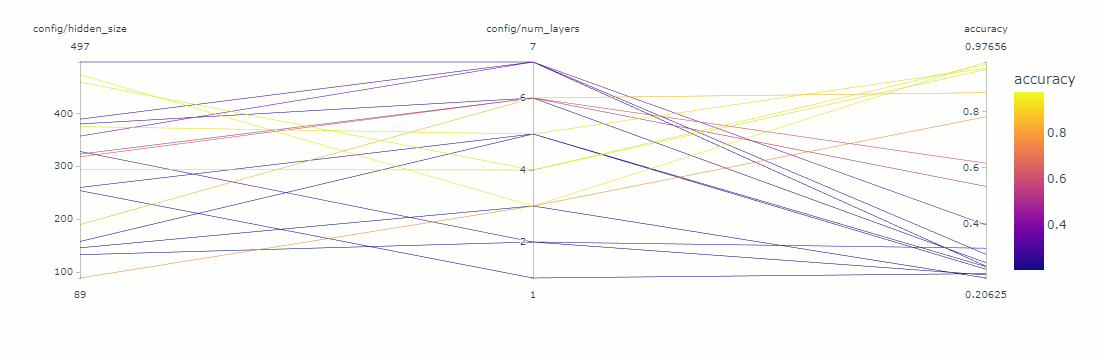

In [83]:
visualize.parallel_plot(analysis, columns)


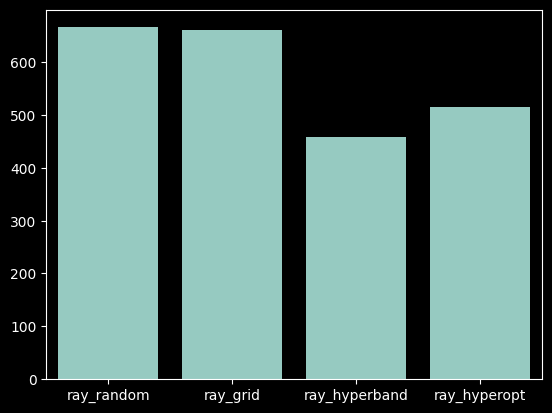

In [84]:
visualize.plot_timers(timer)


In [85]:
pd.DataFrame.from_dict(best_config, orient="index")


,input_size,output_size,dropout,epochs,hidden_size,num_layers,tune_dir,accuracy
random,3,20,0.05,5,497,4,C:\Users\Francesca\Documents\osint\code_repo\A...,0.989062
grid,3,20,0.10,5,512,2,C:\Users\Francesca\Documents\osint\code_repo\A...,0.998438
hyperband,3,20,0.10,5,482,3,C:\Users\Francesca\Documents\osint\code_repo\A...,0.981250
hyperopt,3,20,0.10,5,473,3,C:\Users\Francesca\Documents\osint\code_repo\A...,0.976562


In [86]:
best_hyperbayes = analysis.get_best_config()
best_hyperbayes

{'input_size': 3,
 'output_size': 20,
 'dropout': 0.1,
 'epochs': 5,
 'hidden_size': 473,
 'num_layers': 3,
 'tune_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/dev/notebooks/4_tuning_networks/models/ray'),
 'accuracy': 0.9765625}

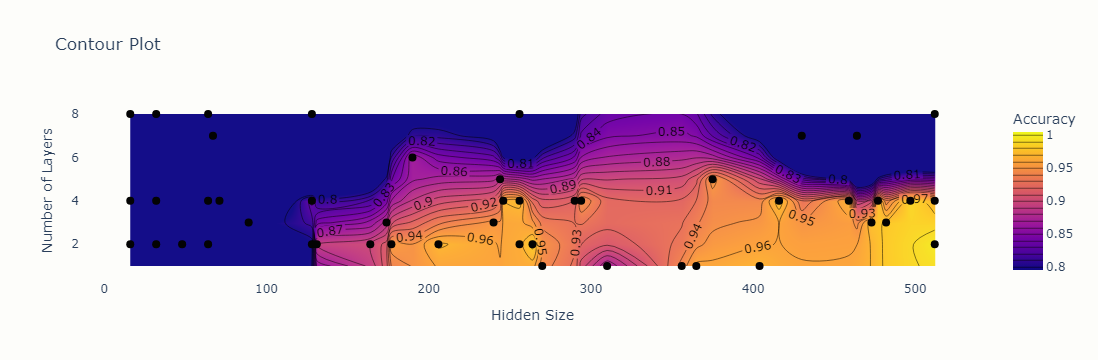

In [87]:
contour = all_results[all_results["training_iteration"] == MAX_EPOCHS]
plot_contour(contour, "config/hidden_size", "config/num_layers", "accuracy", start=0.8)

In [88]:
stop = time.time() - start
print(stop)

11471.066872119904


In [89]:
if DELETE:
    import shutil
    shutil.rmtree(tune_dir)
